epoch 01 | train_loss=4.1211 | val_loss=0.3069
epoch 10 | train_loss=0.2876 | val_loss=0.2867
epoch 20 | train_loss=0.2887 | val_loss=0.2889
epoch 30 | train_loss=0.2865 | val_loss=0.2955
epoch 40 | train_loss=0.2843 | val_loss=0.2890
epoch 50 | train_loss=0.2870 | val_loss=0.2888


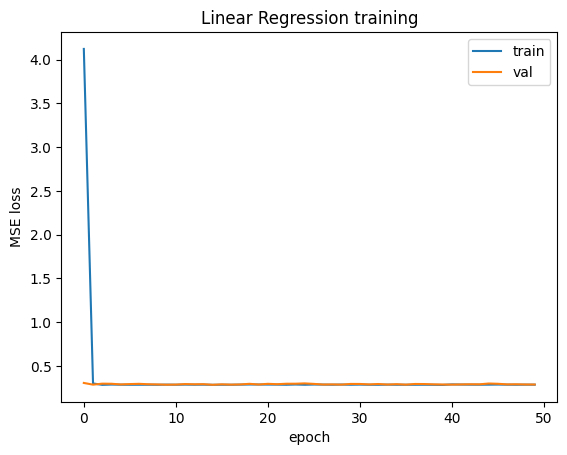

True  W: [[3. 2.]]   True b: [1.]
Learned W: [[2.9800625 2.0135226]]  Learned b: [0.9827401]

Sample preds vs targets (first 5):
tensor([[ 4.7919,  4.7669],
        [-1.9600, -1.5968],
        [-1.1817, -1.6817],
        [-0.9318, -1.2982],
        [ 2.6786,  2.4113]])


In [ ]:
# Level 3 — Linear Regression with many samples, DataLoader, and loss curve

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


N = 500
d = 2
X = torch.randn(N, d)
true_W = torch.tensor([[3.0, 2.0]])
true_b = torch.tensor([1.0])
noise = 0.5 * torch.randn(N, 1)
y = X @ true_W.T + true_b + noise

split = int(0.8 * N)
X_train, y_train = X[:split], y[:split]
X_val,   y_val   = X[split:], y[split:]

X_train, y_train = X_train.to(device), y_train.to(device)
X_val,   y_val   = X_val.to(device),   y_val.to(device)

batch_size = 32
train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val,   y_val)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size)

model = nn.Linear(in_features=d, out_features=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

epochs = 50
train_losses, val_losses = [], []

for epoch in range(1, epochs + 1):
    model.train()
    running_train_loss = 0.0

    for xb, yb in train_dl:
        y_pred = model(xb)
        loss = criterion(y_pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * xb.size(0)

    avg_train_loss = running_train_loss / len(train_ds)

    model.eval()
    with torch.inference_mode():
        val_loss_sum = 0.0
        for xb, yb in val_dl:
            y_pred = model(xb)
            val_loss_sum += criterion(y_pred, yb).item() * xb.size(0)
        avg_val_loss = val_loss_sum / len(val_ds)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | train_loss={avg_train_loss:.4f} | val_loss={avg_val_loss:.4f}")

plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Linear Regression training")
plt.legend()
plt.show()

with torch.no_grad():
    W_learned = model.weight.detach().cpu()
    b_learned = model.bias.detach().cpu()
print("True  W:", true_W.numpy(),  "  True b:", true_b.numpy())
print("Learned W:", W_learned.numpy(), " Learned b:", b_learned.numpy())

with torch.inference_mode():
    preds = model(X_val[:5])
print("\nSample preds vs targets (first 5):")
print(torch.cat([preds.cpu(), y_val[:5].cpu()], dim=1))
